In [1]:
from emulator_utils.pre_process import log_standard, minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp

In [2]:
import matplotlib.pylab as plt
import numpy as np
from glob import glob

### Reading spectra

In [3]:
k, _, _, _ = readpowerspec('../test/data/powerspec_LJ/m000p.pk.499')
fnames = glob('../test/data/powerspec_LJ/*')
pk_all = np.array([readpowerspec(f)[1] for f in fnames])

### Using a pre-processing pipeline

In [4]:
scaled, scaler = log_standard(pk_all)

### Using mock data here, will be rescaled as well

In [5]:
params = np.arange(scaled.shape[0]).reshape(-1, 1)
scaled_y, scaler_y = minmax(params)

In [6]:
pk_train, pk_test, param_train, param_test = random_holdout(scaled, params, split_fraction = 0.2)

Text(0, 0.5, 'Pk')

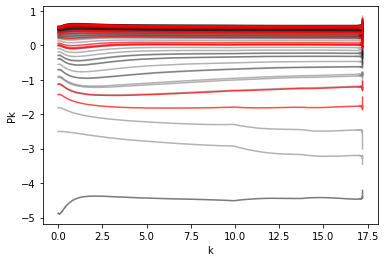

In [7]:
plt.figure(1)
plt.plot(k, pk_train.T, 'k', alpha=0.3)
plt.plot(k, pk_test.T, 'r', alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Sample neural network 

### Fixing the network architecture (hidden_dims is flexible)

In [8]:
mlp = simple_mlp(input_shape=param_train.shape[1], 
                 output_shape=pk_train.shape[1], 
                 hidden_dims=[16, 32, 64, 512])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 512)               33280     
                                                                 
 dense_4 (Dense)             (None, 9311)              4776543   
                                                                 
Total params: 4,812,511
Trainable params: 4,812,511
Non-trainable params: 0
_________________________________________________________________
None


### Set-up hyper-parameters

In [9]:
learning_rate = 0.001
decay_rate = 0.1
batch_size = 4
num_epochs = 20

In [10]:
mlp, train_history = train_mlp(mlp, 
                    param_train, pk_train, param_test, pk_test, 
                    learning_rate, decay_rate, batch_size, num_epochs)

Epoch 1/4
3/3 [==============================] - 44s 2s/step - loss: 31.4443 - binary_crossentropy: 5.7772 - val_loss: 11.5766 - val_binary_crossentropy: 5.0126
Epoch 2/4
3/3 [==============================] - 3s 2s/step - loss: 16.5703 - binary_crossentropy: 5.7207 - val_loss: 8.7123 - val_binary_crossentropy: 5.0267
Epoch 3/4
3/3 [==============================] - 4s 2s/step - loss: 8.6044 - binary_crossentropy: 4.4633 - val_loss: 4.4518 - val_binary_crossentropy: 4.3561
Epoch 4/4
3/3 [==============================] - 4s 2s/step - loss: 5.7263 - binary_crossentropy: 4.5853 - val_loss: 3.6280 - val_binary_crossentropy: 4.6942
Training complete
1/1 [==============================] - 5s 5s/step - loss: 3.6280 - binary_crossentropy: 4.6942
Test loss after training: 3.628


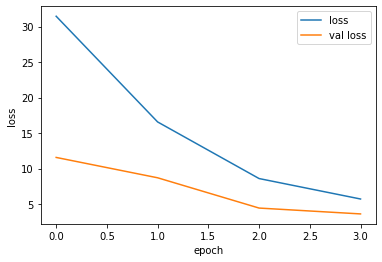

In [11]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
save_mlp(mlp, '../test/model/trained_mlp')
mlp = load_mlp('../test/model/trained_mlp')

2022-04-17 20:24:02.678554: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../test/model/trained_mlp/assets
Model saved at../test/model/trained_mlp


In [23]:
mlp_pred = mlp.predict(param_test)
pk_pred = unscale(mlp_pred, scaler)

Text(0, 0.5, 'Pk')

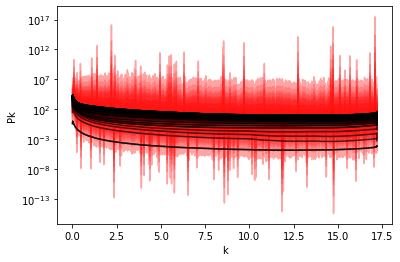

In [31]:
plt.figure(1)
plt.plot(k, pk_pred.T, 'r', alpha=0.2)
plt.plot(k, pk_all.T, 'k', alpha=0.7)

# plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

## explainers 

In [13]:
## local SHAP model
## global ALE model